
## pymc's ADVI implementation for coin toss problem


In [5]:
try:
    import jax
except ModuleNotFoundError:
    %pip install -qqq jax jaxlib
    import jax

import jax.numpy as jnp
from jax import lax

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install -qqq tensorflow_probability
    from tensorflow_probability.substrates import jax as tfp

try:
    import optax
except ModuleNotFoundError:
    %pip install -qqq optax
    import optax

try:
    from rich import print
except ModuleNotFoundError:
    %pip install -qqq rich
    from rich import print

try:
    from tqdm import trange
except ModuleNotFoundError:
    %pip install -qqq tqdm
    from tqdm import trange


import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qqq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml


warnings.filterwarnings("ignore")
dist = tfp.distributions

plt.rc("font", size=10)  # controls default text sizes
plt.rc("axes", labelsize=12)  # fontsize of the x and y labels
plt.rc("legend", fontsize=12)  # legend fontsize
plt.rc("figure", titlesize=15)  # fontsize of the figure title


try:
    import pymc as pm
except ModuleNotFoundError:
    %pip install -qq pymc
    import pymc as pm


try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az

import math

In [12]:
def prior_dist():
    return dist.Beta(concentration1=1.0, concentration0=1.0)


def likelihood_dist(theta):
    return dist.Bernoulli(probs=theta)

## Dataset
Now, we will create the dataset. we sample `theta_true` (probability of occurring head) random variable from the prior distribution which is Beta in this case. Then we sample `n_samples` coin tosses from likelihood distribution which is Bernouli in this case. 

In [10]:
# Use same data as https://github.com/probml/probml-notebooks/blob/main/notebooks/beta_binom_approx_post_pymc.ipynb
key = jax.random.PRNGKey(128)
dataset = np.repeat([0, 1], (10, 1))
n_samples = len(dataset)
print(f"Dataset: {dataset}")
n_heads = dataset.sum()
n_tails = n_samples - n_heads

Dataset: [0 0 0 0 0 0 0 0 0 0 1]

## Prior, Likelihood, and True Posterior  
For coin toss problem, since we know the closed form solution of posterior, we compare the distributions of Prior, Likelihood, and True Posterior below.

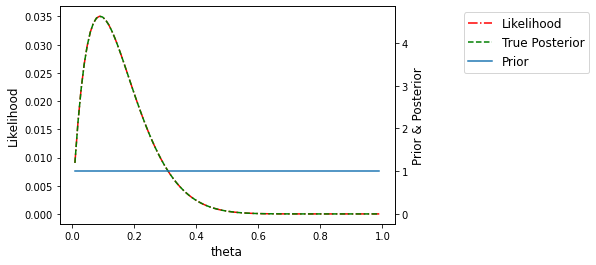

In [13]:
# closed form of beta posterior
a = prior_dist().concentration1
b = prior_dist().concentration0

exact_posterior = dist.Beta(concentration1=a + n_heads, concentration0=b + n_tails)

theta_range = jnp.linspace(0.01, 0.99, 100)

plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
(plt2,) = ax2.plot(theta_range, exact_posterior.prob(theta_range), "g--", label="True Posterior")
(plt3,) = ax2.plot(theta_range, prior_dist().prob(theta_range), label="Prior")

likelihood = jax.vmap(lambda x: jnp.prod(likelihood_dist(x).prob(dataset)))(theta_range)
(plt1,) = ax.plot(theta_range, likelihood, "r-.", label="Likelihood")

ax.set_xlabel("theta")
ax.set_ylabel("Likelihood")
ax2.set_ylabel("Prior & Posterior")
ax2.legend(handles=[plt1, plt2, plt3], bbox_to_anchor=(1.6, 1));

In [14]:
with pm.Model() as mf_model:
    theta = pm.Beta("theta", 1, 1)
    y = pm.Binomial("y", n=1, p=theta, observed=dataset)  # Bernoulli
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean=advi.approx.mean.eval,  # callable that returns mean
        std=advi.approx.std.eval,  # callable that returns std
    )
    approx = advi.fit(callbacks=[tracker], n=20000)

trace_approx = approx.sample(1000)

Finished [100%]: Average Loss = 4.9012
INFO:pymc.variational.inference:Finished [100%]: Average Loss = 4.9012


KeyError: 'theta'

In [38]:
thetas = jnp.array(trace_approx.posterior["theta"]).flatten()

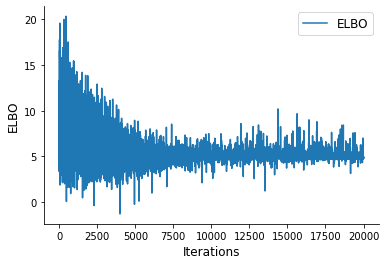

In [39]:
plt.plot(advi.hist, label="ELBO")
plt.xlabel("Iterations")
plt.ylabel("ELBO")
plt.legend()
sns.despine()
plt.savefig("advi_beta_binom_pymc_loss.pdf")
plt.show()

## True posterior & pymc q(x) 

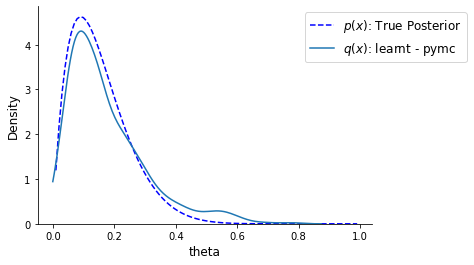

In [40]:
plt.plot(theta_range, exact_posterior.prob(theta_range), "b--", label="$p(x)$: True Posterior")
sns.kdeplot(thetas, label="$q(x)$: learnt - pymc", clip=(0.0, 1.0), bw_adjust=1)
plt.xlabel("theta")
plt.legend(bbox_to_anchor=(1.3, 1))
sns.despine()

## Plot of loc and scale for variational distribution

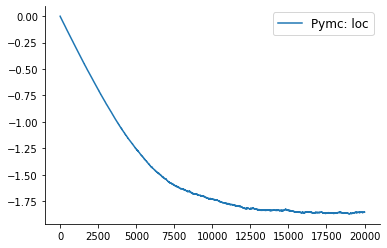

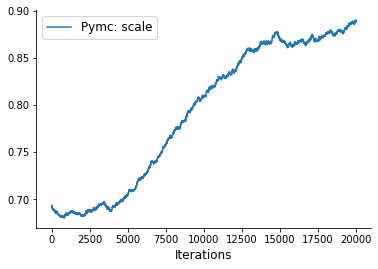

In [43]:
# pymc
fig, ax2 = plt.subplots()
ax2.plot(tracker["mean"], label="Pymc: loc")
ax2.legend()
sns.despine()

# pymc
fig, ax4 = plt.subplots()
ax4.plot(tracker["std"], label="Pymc: scale")
ax4.set_xlabel("Iterations")
ax4.legend()

sns.despine();